In [49]:
cd /home/kk/jupyter/stock_prediction/

/home/kk/jupyter/stock_prediction


In [50]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [51]:
def readData(file):
    mlist = []
    with open(file, 'r', encoding='utf-8') as file:
        while True:
            line = file.readline()
            if len(line) == 0:
                break
            mjson = json.loads(line)
            mlist.append([mjson['level'], mjson['mouth']])
    return pd.DataFrame(mlist)

### 數據規一化

將所有值映射到[0, 1]之間

https://blog.csdn.net/weixin_40683253/article/details/81508321

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [52]:
from sklearn.preprocessing import MinMaxScaler
def normalize(train):
    scaler = MinMaxScaler()
    train_norm = scaler.fit_transform(train)
    return train_norm

In [53]:
def buildTrain(train, long=30):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-long):
    X_train.append(train[i:i+long,1:])
    Y_train.append(train[i+long-1][0])
  return np.array(X_train), np.array(Y_train)

In [54]:
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [55]:
def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [56]:
train = readData('output.txt')
train_norm = normalize(train)
X_train, Y_train = buildTrain(train_norm, 100)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'Y_val: {Y_val.shape}')

X_train: (641, 100, 1)
Y_train: (641,)
X_val: (71, 100, 1)
Y_val: (71,)


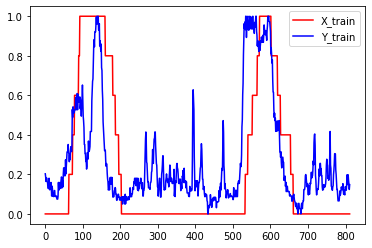

In [57]:
plt.plot(train_norm[:,0], color='r', label='X_train')
plt.plot(train_norm[:,1], color='b', label='Y_train')
plt.legend()
plt.show()

In [58]:
model = Sequential([
    LSTM(10, input_shape=X_train.shape[1:]),
    Dense(1)
])
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [59]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
trainHistory = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Train on 641 samples, validate on 71 samples
Epoch 1/1000
641/641 [==============================] - 1s 2ms/step - loss: 0.3067 - val_loss: 0.3326
Epoch 2/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.2701 - val_loss: 0.2931
Epoch 3/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.2403 - val_loss: 0.2592
Epoch 4/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.2152 - val_loss: 0.2306
Epoch 5/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.1934 - val_loss: 0.2047
Epoch 6/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.1737 - val_loss: 0.1801
Epoch 7/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.1541 - val_loss: 0.1567
Epoch 8/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.1364 - val_loss: 0.1332
Epoch 9/1000
641/641 [==============================] - 1s 1ms/step - loss: 0.1174 - val_loss: 0.1120
Epoch 10/1000
641/641 [==============

### 繪製Loss線

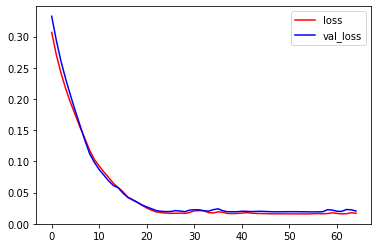

In [60]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

### 匯出模型

In [61]:
model.save('model.h5')

# 測試模型

In [62]:
from keras.models import load_model
my_model = load_model('model.h5')

In [63]:
test = readData('output2.txt')
test_norm = normalize(test)
X_test, Y_test = buildTrain(test_norm, 100)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(f'X_test: {X_test.shape}')
print(f'Y_test: {Y_test.shape}')

X_test: (330, 100, 1)
Y_test: (330,)


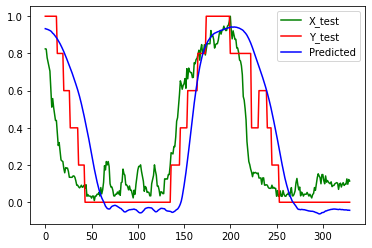

In [64]:
predicted = my_model.predict(X_test)
plt.plot(test_norm[100:,1], color='g', label='X_test')
plt.plot(Y_test, color='r', label='Y_test')
plt.plot(predicted, color='b', label='Predicted')
plt.legend()
plt.show()